In [1]:
from xmitgcm import open_mdsdataset
import xgcm
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import xarray as xr
os.chdir('/home/jxchang/scratch/HighRes1/results/TideU008N0LinTopConstH200ho1402DAh0200Cdqdt003/python/')
import vertmodes
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings

warnings.filterwarnings('ignore')

In [2]:
currentDirectory = os.getcwd()
data_dir = currentDirectory[:-7] + '/input/'
print(data_dir)

/scratch/jxchang/HighRes1/results/TideU008N0LinTopConstH200ho1402DAh0200Cdqdt003/input/


In [3]:
iT=range(3,6)
P=12.4*60*60
dt=1860
t_st=int(P*iT[0])
t_en=int(P*(iT[-1]))
iters=range(t_st,t_en,dt)
print(iters)

range(133920, 223200, 1860)


In [4]:
ds1 = open_mdsdataset(data_dir, geometry='cartesian',endian='<',prefix=['statevars'],iters=iters)
tidaltime = ds1.time / pd.Timedelta("12.4h")
ds1=ds1.assign_coords(TidalCycles=("time", tidaltime.data))

In [5]:
time=ds1.coords['time'].values/np.timedelta64(1, 's')
#time=ds2.coords['time'].values/np.timedelta64(1, 's')
xc=ds1.coords['XC']
xg=ds1.coords['XG']
yc=ds1.coords['YC']
yg=ds1.coords['YG']
z=ds1.coords['Z']
zp1=ds1.coords['Zp1']
dz=-np.median(np.diff(z))


ds1=ds1.swap_dims({'time': 'TidalCycles'})
print(ds1)
grid = xgcm.Grid(ds1, periodic=False)
print(grid)

<xarray.Dataset>
Dimensions:      (TidalCycles: 48, XC: 1440, XG: 1440, YC: 120, YG: 120, Z: 40, Zl: 40, Zp1: 41, Zu: 40)
Coordinates:
  * XC           (XC) float64 356.8 1.06e+03 1.745e+03 ... 7.894e+04 7.964e+04
  * YC           (YC) float64 12.5 37.5 62.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04
  * YG           (YG) float64 0.0 25.0 50.0 ... 2.925e+03 2.95e+03 2.975e+03
  * Z            (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -187.5 -192.5 -197.5
  * Zp1          (Zp1) float64 0.0 -5.0 -10.0 -15.0 ... -190.0 -195.0 -200.0
  * Zu           (Zu) float64 -5.0 -10.0 -15.0 -20.0 ... -190.0 -195.0 -200.0
  * Zl           (Zl) float64 0.0 -5.0 -10.0 -15.0 ... -185.0 -190.0 -195.0
    rA           (YC, XC) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    dxG          (YG, XC) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    dyG          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=

In [6]:
t = 0
f0 = 1.e-4
g = 9.8
rhoNil=999.8

om=2*np.pi/12.4/3600
alpha = 2e-4
beta = 0.
nz = 200
#dz=H/nz 
tR_fname="../indata/TRef.bin"
tRef = np.fromfile(tR_fname)
refSalt=35.
refTemp=tRef[0]

rho2=rhoNil*(1-(alpha*(tRef-refTemp)))
print(rho2)
s = InterpolatedUnivariateSpline(-z.values, rho2, k=1)
rhol=s(-zp1.values)
Ns0=g/rhoNil*np.diff(rhol)/ds1['drF'].values
print(Ns0)
ds1["Ns0"]=xr.DataArray(Ns0,coords=[z],dims=["Z"])
ds1['tRef']=xr.DataArray(tRef,coords=[z],dims=['Z'])

[ 999.8         999.8510102   999.90202041  999.95303061 1000.06394071
 1000.52583109 1000.59217032 1000.69077578 1000.78345843 1000.90488379
 1001.09910071 1001.11977244 1001.16697739 1001.26856567 1001.39835508
 1001.42171434 1001.44116311 1001.45693638 1001.46213764 1001.47628197
 1001.4876212  1001.49653443 1001.4998263  1001.50363658 1001.50442724
 1001.50535242 1001.51309906 1001.51505553 1001.51586053 1001.51677087
 1001.51768745 1001.51914221 1001.52155593 1001.52483629 1001.52811665
 1001.53139701 1001.53467737 1001.53795773 1001.54123809 1001.54451845]
[1.00000000e-04 1.00000000e-04 1.00000000e-04 1.58713635e-04
 5.61456761e-04 5.17768575e-04 1.61678133e-04 1.87499848e-04
 2.09867824e-04 3.09391310e-04 2.10633001e-04 6.65324563e-05
 1.45846535e-04 2.26795495e-04 1.50115723e-04 4.19602629e-05
 3.45245030e-05 2.05591541e-05 1.89624692e-05 2.49788827e-05
 1.98513844e-05 1.19633836e-05 6.96149270e-06 4.50982323e-06
 1.68185900e-06 8.50009242e-06 9.51095497e-06 2.70677632e-06
 1.6

In [7]:
ttlen=len(ds1.time)
TC=np.int(np.floor(ttlen/24))
print('the length of time:' + str(ttlen) )
print('initial temp: '+ str(tRef))
print('number of tidal cycle:'+ str(TC))

the length of time:48
initial temp: [32.44489796 32.18979592 31.93469388 31.67959184 31.12493043 28.81501653
 28.48325403 27.99012809 27.52662215 26.91937388 25.94809506 25.84471572
 25.60864375 25.10060074 24.45152388 24.3347042  24.23744091 24.15855878
 24.13254726 24.06181148 24.00510399 23.96052891 23.94406631 23.92501109
 23.92105701 23.91643018 23.87768919 23.8679049  23.86387911 23.85932652
 23.85474268 23.8474674  23.8353964  23.81899132 23.80258624 23.78618117
 23.76977609 23.75337101 23.73696593 23.72056085]
number of tidal cycle:2


In [8]:
psi,phi,ce,zph = vertmodes.vertModes(Ns0,dz)
print(np.shape(psi))
for i in range(4):
    print('int psi 0 psi %d:  %1.2e'%(i,np.sum(psi[:,0]*psi[:,i]*dz)))

(40, 37)
int psi 0 psi 0:  1.00e+00
int psi 0 psi 1:  1.62e-13
int psi 0 psi 2:  5.08e-13
int psi 0 psi 3:  1.49e-13


In [9]:
#adjust the normalization of vertical mode to H
nmodes=range(1,38)
H=ds1.drF.sum("Z").values
df = xr.Dataset({"psi": (["nmodes", "Z"],np.transpose(psi)*H**0.5), "phi": (["nmodes", "Z"],np.transpose(phi)*H**0.5)},coords={"nmodes":nmodes,"Z":z})
print(df)
print('int psi 0 psi 0:  ')
print((df.psi[0]*df.psi[0]*dz).sum("Z").values)
print((df.psi[0]*df.psi[1]*dz).sum("Z").values)
print((df.psi[0]*df.psi[2]*dz).sum("Z").values)
print((df.psi[0]*df.psi[3]*dz).sum("Z").values)
print((df.psi[1]*df.psi[1]*dz).sum("Z").values)
print((df.psi[2]*df.psi[2]*dz).sum("Z").values)
print((df.psi[3]*df.psi[3]*dz).sum("Z").values)

<xarray.Dataset>
Dimensions:  (Z: 40, nmodes: 37)
Coordinates:
  * nmodes   (nmodes) int64 1 2 3 4 5 6 7 8 9 10 ... 29 30 31 32 33 34 35 36 37
    drF      (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    PHrefC   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    rhoRef   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
  * Z        (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -182.5 -187.5 -192.5 -197.5
Data variables:
    psi      (nmodes, Z) float64 2.249 2.234 2.203 ... 3.21e-05 -6.78e-06
    phi      (nmodes, Z) float64 1.125 3.366 5.584 ... -9.272e-06 3.39e-06
int psi 0 psi 0:  
200.0
3.240074875066057e-11
1.0152234608540311e-10
2.986411118399701e-11
200.0
200.00000000000006
200.00000000000009


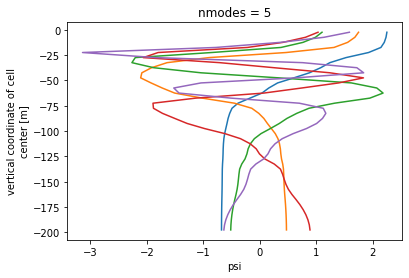

In [10]:
f,ax=plt.subplots()
df.psi[0].plot(ax=ax,y="Z")
df.psi[1].plot(ax=ax,y="Z")
df.psi[2].plot(ax=ax,y="Z")
df.psi[3].plot(ax=ax,y="Z")
df.psi[4].plot(ax=ax,y="Z")

In [11]:
print(df.psi[0].sum("Z").values)

0.0


In [12]:
df['ce']=xr.DataArray(ce,coords=[nmodes],dims=["nmodes"])

In [13]:
iy1=50
VW=grid.interp(ds1['VVEL'],axis=('X','Y'),boundary='extrapolate')
for iy in range(iy1,iy1+1):
    U0=(ds1['UVEL']*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).isel(YC=iy).sum('Z')
    VW0=(VW*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).isel(YC=iy).sum('Z')
    VS0=(ds1['VVEL'].isel(YG=iy)*ds1['drF']*ds1['hFacS']*ds1['maskS']).sum('Z')/(ds1.drF*ds1.hFacS*ds1.maskS).isel(YG=iy).sum('Z')
    PW=grid.interp(ds1['PHIHYD'],axis='X',boundary='extrapolate')
    PS=grid.interp(ds1['PHIHYD'],axis='Y',boundary='extrapolate')
    #print(PW[2,60:63,723:726].values)
    #print(PS[2,60:63,723:726].values)
    PW0=(PW*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).isel(YC=iy).sum('Z')
    PS0=(PS*ds1['drF']*ds1['hFacS']*ds1['maskS']).isel(YG=iy).sum('Z')/(ds1.drF*ds1.hFacS*ds1.maskS).isel(YG=iy).sum('Z')
    #print(PW0[60:63,723:726].values)

    up=(ds1.UVEL.isel(YC=iy)-U0).where(ds1.maskW.isel(YC=iy)!=0,np.nan)
    print('processed up')
    vwp=(VW.isel(YC=iy)-VW0).where(ds1.maskW.isel(YC=iy)!=0,np.nan)
    vsp=(ds1.VVEL.isel(YG=iy)-VS0).where(ds1.maskS.isel(YG=iy)!=0,np.nan)
    print('vp')
    ppw=((PW-PW0).isel(YC=iy)).where(ds1.maskW.isel(YC=iy)!=0,np.nan)
    print('ppw')
    pps=((PS-PS0).isel(YG=iy)).where(ds1.maskS.isel(YG=iy)!=0,np.nan)
    print('pps')
    del U0,VS0,VW0,PW0,PS0

    um=(up*df.psi*ds1.drF).sum("Z")/H
    pmw=(ppw*df.psi*ds1.drF).sum("Z")/H
    vms=(vsp*df.psi*ds1.drF).sum("Z")/H
    vmw=(vwp*df.psi*ds1.drF).sum("Z")/H
    pms=(pps*df.psi*ds1.drF).sum("Z")/H
    fxm=um*pmw*H
    fym=vms*pms*H
    EKm=0.5*(um*um+vmw*vmw)*H
    EPm=0.5*(pmw*pmw/df.ce/df.ce)*H
    Em=EKm+EPm
    print(Em)
    cEm=xr.concat([-df.ce*Em[:, :720,:], df.ce*Em[:, 720:,:]], dim="XG")
    print(cEm)

BCrad=0
del vsp,pps

processed up
vp
ppw
pps
<xarray.DataArray (TidalCycles: 48, XG: 1440, nmodes: 37)>
dask.array<add, shape=(48, 1440, 37), dtype=float64, chunksize=(1, 1439, 37), chunktype=numpy.ndarray>
Coordinates:
    YC           float64 1.262e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04
    dyG          (XG) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    dxC          (XG) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    rAw          (XG) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    maskInW      (XG) bool dask.array<chunksize=(1440,), meta=np.ndarray>
    iter         (TidalCycles) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time         (TidalCycles) timedelta64[ns] 1 days 13:12:00 ... 2 days 13:...
  * TidalCycles  (TidalCycles) float64 3.0 3.042 3.083 ... 4.875 4.917 4.958
  * nmodes       (nmodes) int64 1 2 3 4 5 6 7 8 9 ... 29 30 31 32 33 34 35 36 37
<xarray.DataArray (nmodes: 37, TidalCycles: 48, XG: 1440)>
da

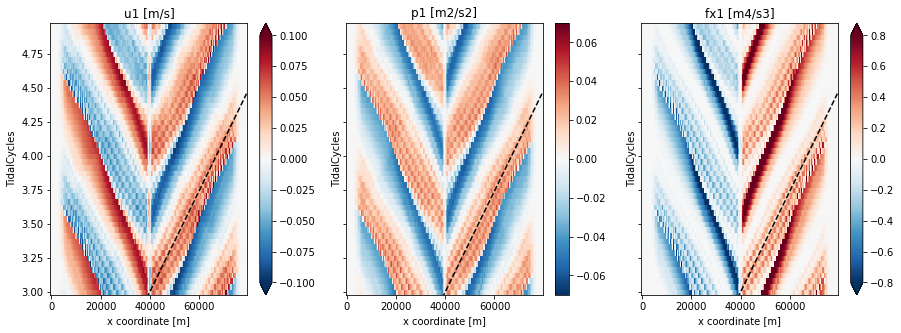

In [14]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=1).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[0].set_title("u1 [m/s]")
ax[0].plot(xg,(xg-40000)/ce[0]/(12.4*3600)+3,'k--')

pmw.sel(nmodes=1).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.07,vmax=0.07,rasterized=True)
ax[1].set_title("p1 [m2/s2]")
ax[1].plot(xg,(xg-40000)/ce[0]/(12.4*3600)+3,'k--')

fxm.sel(nmodes=1).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.8,vmax=0.8,rasterized=True)
ax[2].set_title("fx1 [m4/s3]")
ax[2].plot(xg,(xg-40000)/ce[0]/(12.4*3600)+3,'k--')

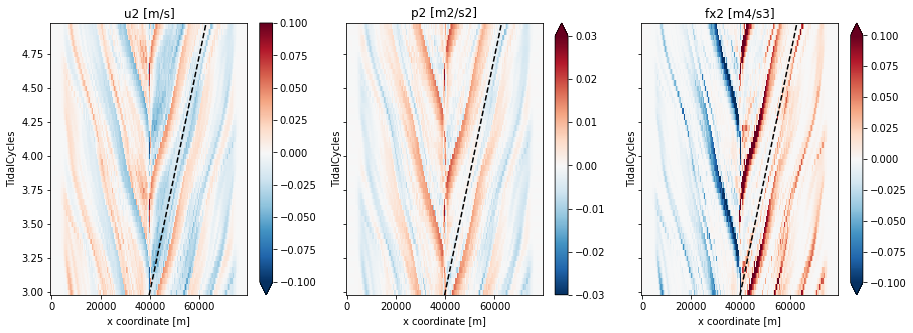

In [15]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=2).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[0].set_title("u2 [m/s]")
ax[0].plot(xg,(xg-40000)/ce[1]/(12.4*3600)+3,'k--')

pmw.sel(nmodes=2).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.03,vmax=0.03,rasterized=True)
ax[1].set_title("p2 [m2/s2]")
ax[1].plot(xg,(xg-40000)/ce[1]/(12.4*3600)+3,'k--')

fxm.sel(nmodes=2).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[2].set_title("fx2 [m4/s3]")
ax[2].plot(xg,(xg-40000)/ce[1]/(12.4*3600)+3,'k--')

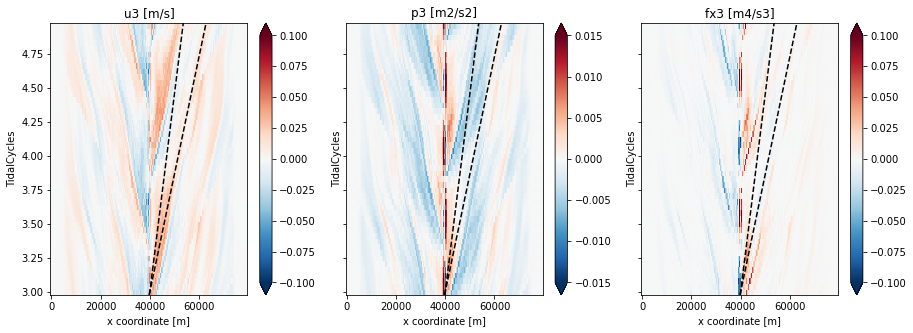

In [16]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=3).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[0].set_title("u3 [m/s]")
ax[0].plot(xg,(xg-40000)/ce[2]/(12.4*3600)+3,'k--')
ax[0].plot(xg,(xg-40000)/ce[1]/(12.4*3600)+3,'k--')


pmw.sel(nmodes=3).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.015,vmax=0.015,rasterized=True)
ax[1].set_title("p3 [m2/s2]")
ax[1].plot(xg,(xg-40000)/ce[2]/(12.4*3600)+3,'k--')
ax[1].plot(xg,(xg-40000)/ce[1]/(12.4*3600)+3,'k--')


fxm.sel(nmodes=3).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[2].set_title("fx3 [m4/s3]")
ax[2].plot(xg,(xg-40000)/ce[2]/(12.4*3600)+3,'k--')
ax[2].plot(xg,(xg-40000)/ce[1]/(12.4*3600)+3,'k--')


Text(0.5, 1.0, 'fx2+fx3 [m4/s3]')

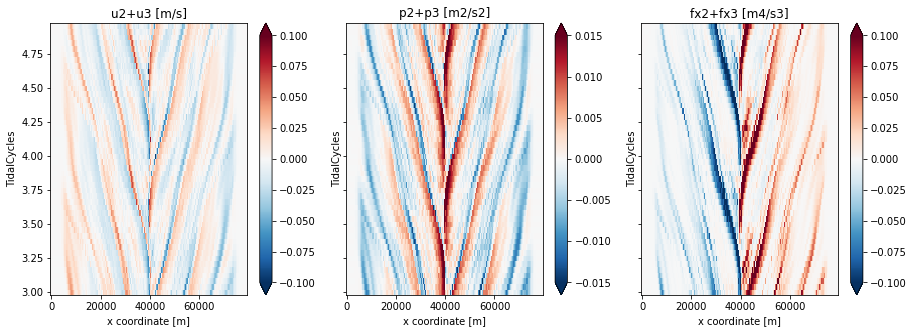

In [17]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

(um.sel(nmodes=2)+um.sel(nmodes=3)).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[0].set_title("u2+u3 [m/s]")

(pmw.sel(nmodes=2)+pmw.sel(nmodes=3)).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.015,vmax=0.015,rasterized=True)
ax[1].set_title("p2+p3 [m2/s2]")

(fxm.sel(nmodes=2)+fxm.sel(nmodes=3)).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[2].set_title("fx2+fx3 [m4/s3]")

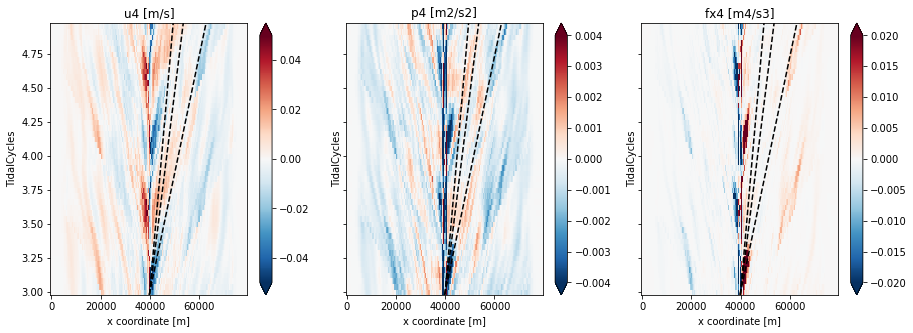

In [18]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=4).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.05,vmax=0.05,rasterized=True)
ax[0].set_title("u4 [m/s]")
ax[0].plot(xg,(xg-40000)/ce[3]/(12.4*3600)+3,'k--')
ax[0].plot(xg,(xg-40000)/ce[2]/(12.4*3600)+3,'k--')
ax[0].plot(xg,(xg-40000)/ce[1]/(12.4*3600)+3,'k--')

pmw.sel(nmodes=4).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.004,vmax=0.004,rasterized=True)
ax[1].set_title("p4 [m2/s2]")
ax[1].plot(xg,(xg-40000)/ce[3]/(12.4*3600)+3,'k--')
ax[1].plot(xg,(xg-40000)/ce[2]/(12.4*3600)+3,'k--')
ax[1].plot(xg,(xg-40000)/ce[1]/(12.4*3600)+3,'k--')

fxm.sel(nmodes=4).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.02,vmax=0.02,rasterized=True)
ax[2].set_title("fx4 [m4/s3]")
ax[2].plot(xg,(xg-40000)/ce[3]/(12.4*3600)+3,'k--')
ax[2].plot(xg,(xg-40000)/ce[2]/(12.4*3600)+3,'k--')
ax[2].plot(xg,(xg-40000)/ce[1]/(12.4*3600)+3,'k--')

Text(0.5, 1.0, 'fx5 [m4/s3]')

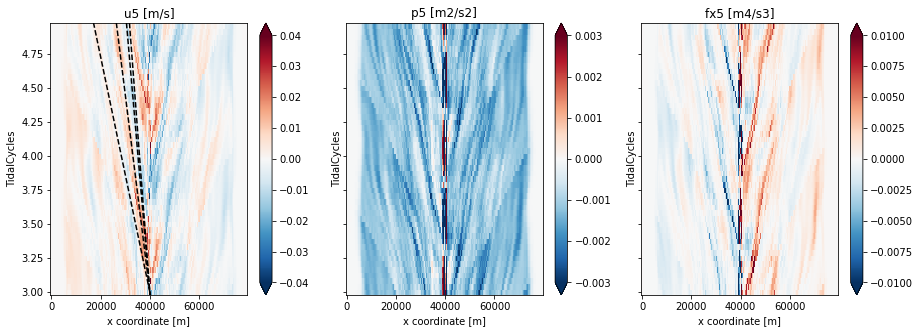

In [19]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=5).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.04,vmax=0.04,rasterized=True)
ax[0].set_title("u5 [m/s]")
ax[0].plot(xg,-(xg-40000)/ce[4]/(12.4*3600)+3,'k--')
ax[0].plot(xg,-(xg-40000)/ce[3]/(12.4*3600)+3,'k--')
ax[0].plot(xg,-(xg-40000)/ce[2]/(12.4*3600)+3,'k--')
ax[0].plot(xg,-(xg-40000)/ce[1]/(12.4*3600)+3,'k--')

pmw.sel(nmodes=5).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.003,vmax=0.003,rasterized=True)
ax[1].set_title("p5 [m2/s2]")

fxm.sel(nmodes=5).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.01,vmax=0.01,rasterized=True)
ax[2].set_title("fx5 [m4/s3]")

Text(0.5, 1.0, 'fx6 [m4/s3]')

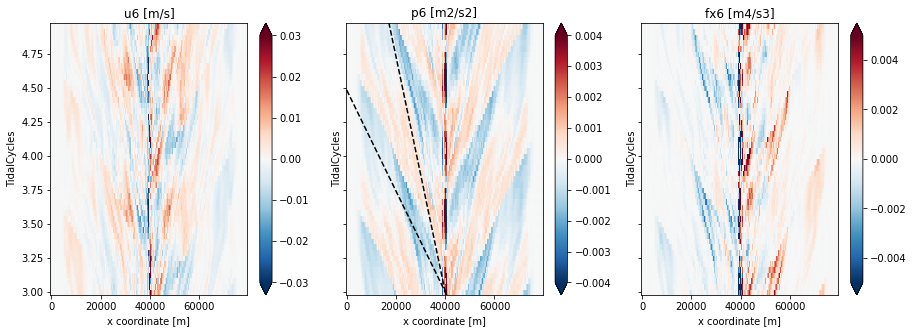

In [20]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=6).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.03,vmax=0.03,rasterized=True)
ax[0].set_title("u6 [m/s]")

pmw.sel(nmodes=6).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.004,vmax=0.004,rasterized=True)
ax[1].set_title("p6 [m2/s2]")
ax[1].plot(xg,-(xg-40000)/ce[0]/(12.4*3600)+3,'k--')
ax[1].plot(xg,-(xg-40000)/ce[1]/(12.4*3600)+3,'k--')

fxm.sel(nmodes=6).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.005,vmax=0.005,rasterized=True)
ax[2].set_title("fx6 [m4/s3]")

In [21]:
ds2 = open_mdsdataset(data_dir, geometry='cartesian',endian='<',prefix=['energymvars'],iters=iters)
uPbc=xr.DataArray(ds2['SDIAG6'].data, coords=[tidaltime,yc,xg], dims=['TidalCycles','YC','XG'])
print(uPbc)

<xarray.DataArray 'concatenate-432472839516d83df0bb302362f00c99' (TidalCycles: 48, YC: 120, XG: 1440)>
dask.array<concatenate, shape=(48, 120, 1440), dtype=float64, chunksize=(1, 120, 1440), chunktype=numpy.ndarray>
Coordinates:
  * TidalCycles  (TidalCycles) float64 3.0 3.042 3.083 ... 4.875 4.917 4.958
  * YC           (YC) float64 12.5 37.5 62.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04


Text(0.5, 1.0, 'total sum of cE')

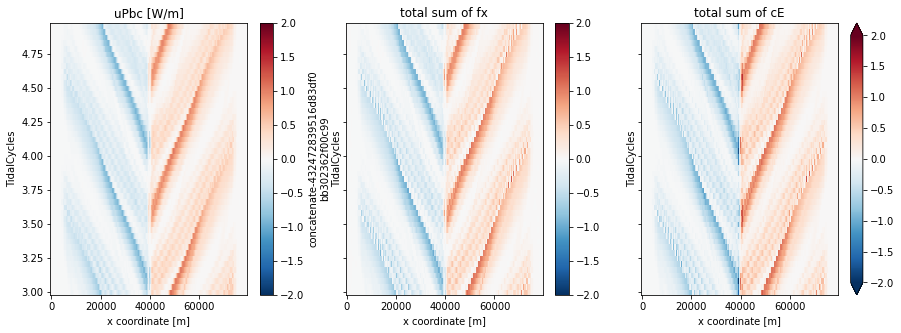

In [22]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

uPbc.isel(YC=iy1).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-2,vmax=2)
ax[0].set_title("uPbc [W/m]")

fxm.sum("nmodes").plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-2,vmax=2)
ax[1].set_title("total sum of fx")

cEm.sum("nmodes").plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-2,vmax=2)
ax[2].set_title("total sum of cE")

(-0.5, 0.5)

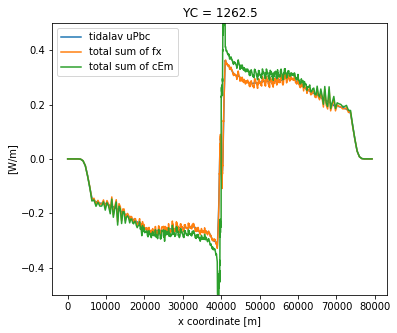

In [23]:
f, ax =plt.subplots(1,1,figsize=(6,5))

uPbc.isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav uPbc")
fxm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of fx")
cEm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of cEm")
ax.set_ylabel("[W/m]")
ax.legend()
ax.set_ylim(-0.5,0.5)

In [24]:
EK = 0.5*(ds1.UVEL*ds1.UVEL+VW*VW)
EKp = 0.5*(up*up+vwp*vwp)
print(EK)
print(EKp)

<xarray.DataArray (TidalCycles: 48, Z: 40, YC: 120, XG: 1440)>
dask.array<mul, shape=(48, 40, 120, 1440), dtype=float64, chunksize=(1, 40, 119, 1439), chunktype=numpy.ndarray>
Coordinates:
  * YC           (YC) float64 12.5 37.5 62.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04
  * Z            (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -187.5 -192.5 -197.5
    dyG          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    dxC          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    rAw          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    drF          (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    PHrefC       (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    hFacW        (Z, YC, XG) float64 dask.array<chunksize=(40, 120, 1440), meta=np.ndarray>
    maskW        (Z, YC, XG) bool dask.array<chunksize=(40, 120, 1440), meta=np.n

Text(0.5, 1.0, 'total sum of EKn')

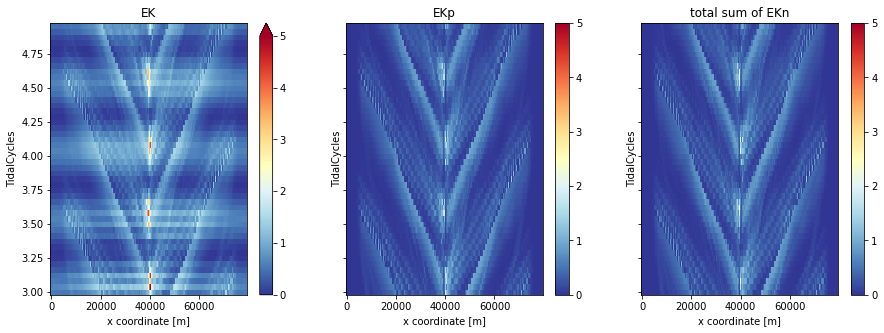

In [25]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

(EK*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(YC=iy1).plot(ax=ax[0],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[0].set_title("EK")

(EKp*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy1).sum('Z').plot(ax=ax[1],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[1].set_title("EKp")

EKm.sum("nmodes").plot(ax=ax[2],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[2].set_title("total sum of EKn")

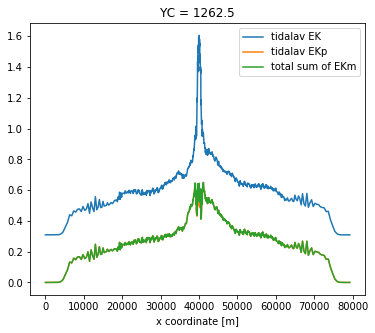

In [26]:
f, ax =plt.subplots(1,1,figsize=(6,5))

(EK*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav EK")
(EKp*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav EKp")
EKm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of EKm")
ax.legend()

In [27]:
rhow=rhoNil*(-(alpha*(ds1.THETA-ds1.tRef)))

In [28]:
print(rhow.isel(TidalCycles=0,YC=50,XC=700).values)

[ 0.02468731 -0.0159627  -0.03310464 -0.007376    0.0387266  -0.16016709
  0.0418011   0.22431542  0.35025421  0.36740791  0.27474911  0.33867785
  0.33074993  0.23686815  0.10905779  0.08684668  0.06849062  0.05381692
  0.04870229  4.81139982  4.80006059  4.79114736  4.7878555   4.78404522
  4.78325456  4.78232938  4.77458273  4.77262626  4.77182127  4.77091093
  4.76999435  4.76853958  4.76612586  4.76284551  4.75956515  4.75628479
  4.75300443  4.74972407  4.74644371  4.74316335]


In [29]:
EP=g*g*rhow*rhow/(2*rhoNil*rhoNil*ds1.Ns0)

Text(0.5, 1.0, 'total sum of EPn')

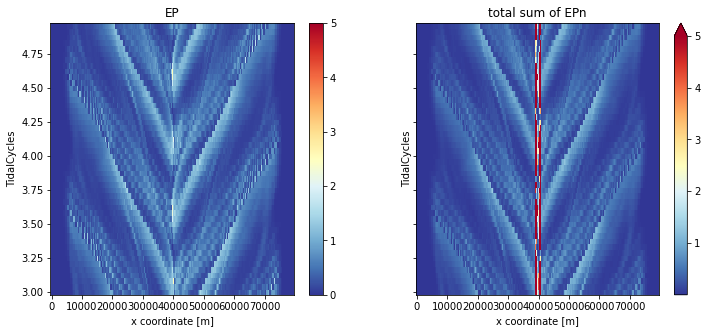

In [30]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

(EP*ds1['drF']*ds1['hFacC']*ds1['maskC']).sum('Z').isel(YC=iy1).plot(ax=ax[0],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[0].set_title("EP")

EPm.sum("nmodes").plot(ax=ax[1],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[1].set_title("total sum of EPn")

(-0.1, 2.0)

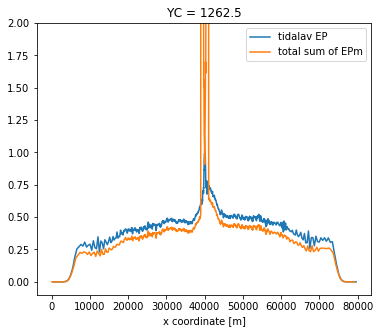

In [31]:
f, ax =plt.subplots(1,1,figsize=(6,5))

(EP*ds1['drF']*ds1['hFacC']*ds1['maskC']).sum('Z').isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav EP")
EPm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of EPm")
ax.legend()
ax.set_ylim(-0.1,2)

Text(0.5, 1.0, 'Fx1 at Y= 1262.500000')

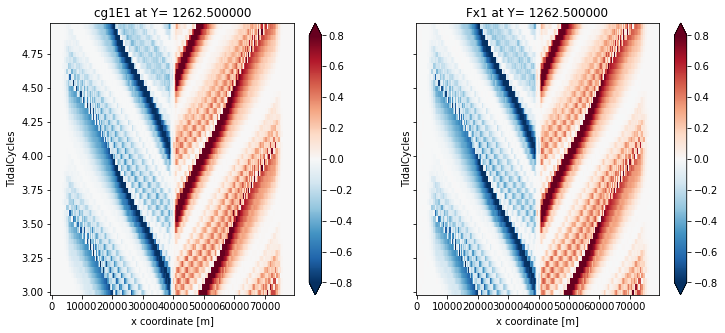

In [32]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=1).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.8,vmax=0.8,rasterized=True)
ax[0].set_title("cg1E1 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=1).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.8,vmax=0.8,rasterized=True)
ax[1].set_title("Fx1 at Y= %1f" %yc[iy1])

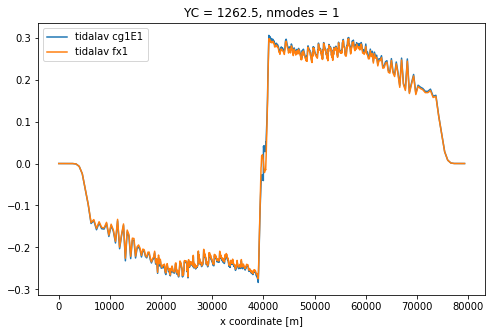

In [33]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=1).plot(ax=ax,label="tidalav cg1E1")
fxm.mean("TidalCycles").sel(nmodes=1).plot(ax=ax,label="tidalav fx1")

ax.legend()

Text(0.5, 1.0, 'Fx2 at Y= 1262.500000')

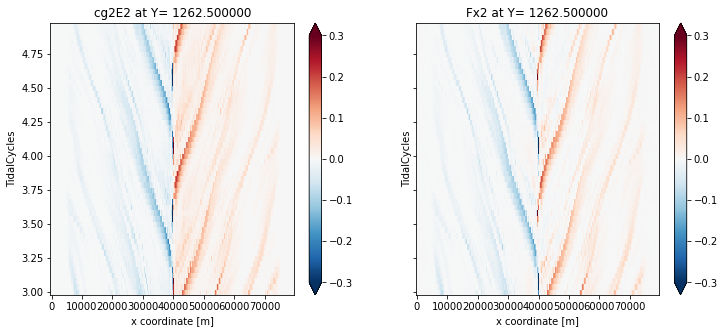

In [34]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=2).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.3,vmax=0.3,rasterized=True)
ax[0].set_title("cg2E2 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=2).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.3,vmax=0.3,rasterized=True)
ax[1].set_title("Fx2 at Y= %1f" %yc[iy1])

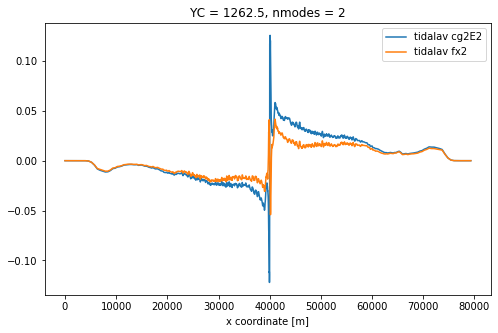

In [35]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=2).plot(ax=ax,label="tidalav cg2E2")
fxm.mean("TidalCycles").sel(nmodes=2).plot(ax=ax,label="tidalav fx2")

ax.legend()

Text(0.5, 1.0, 'Fx3 at Y= 1262.500000')

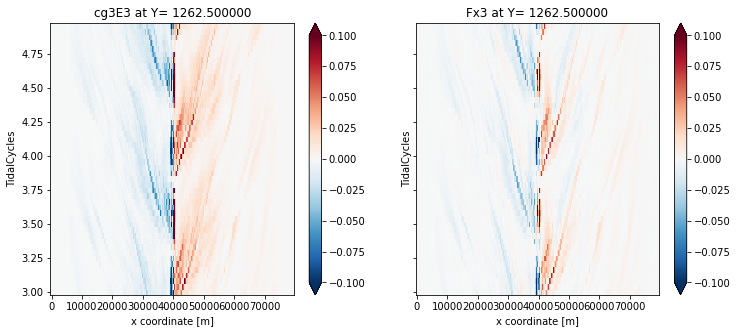

In [36]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=3).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[0].set_title("cg3E3 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=3).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[1].set_title("Fx3 at Y= %1f" %yc[iy1])

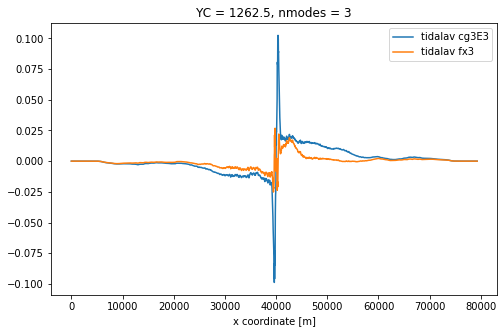

In [37]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=3).plot(ax=ax,label="tidalav cg3E3")
fxm.mean("TidalCycles").sel(nmodes=3).plot(ax=ax,label="tidalav fx3")

ax.legend()

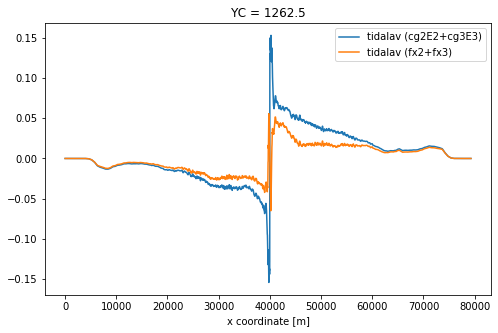

In [38]:
f, ax =plt.subplots(1,1,figsize=(8,5))

(cEm.sel(nmodes=2)+cEm.sel(nmodes=3)).mean("TidalCycles").plot(ax=ax,label="tidalav (cg2E2+cg3E3)")
(fxm.sel(nmodes=2)+fxm.sel(nmodes=3)).mean("TidalCycles").plot(ax=ax,label="tidalav (fx2+fx3)")

ax.legend()

Text(0.5, 1.0, 'Fx4 at Y= 1262.500000')

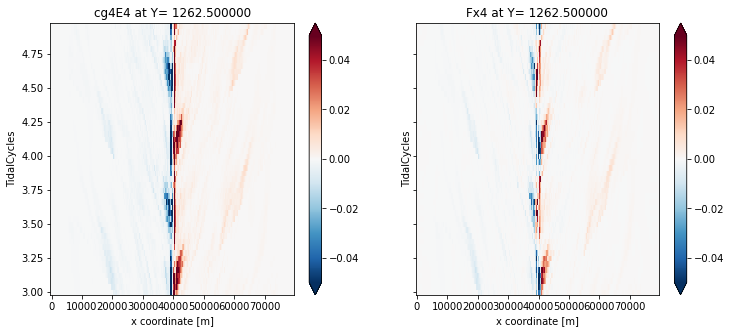

In [39]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=4).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.05,vmax=0.05,rasterized=True)
ax[0].set_title("cg4E4 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=4).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.05,vmax=0.05,rasterized=True)
ax[1].set_title("Fx4 at Y= %1f" %yc[iy1])

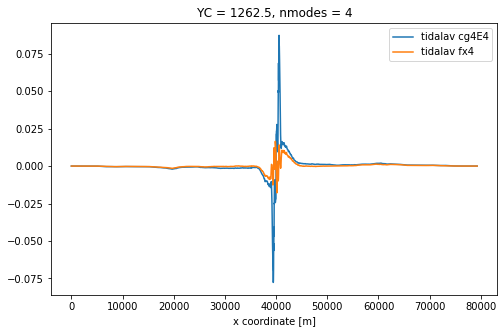

In [40]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=4).plot(ax=ax,label="tidalav cg4E4")
fxm.mean("TidalCycles").sel(nmodes=4).plot(ax=ax,label="tidalav fx4")

ax.legend()

Text(0.5, 1.0, 'Fx5 at Y= 1262.500000')

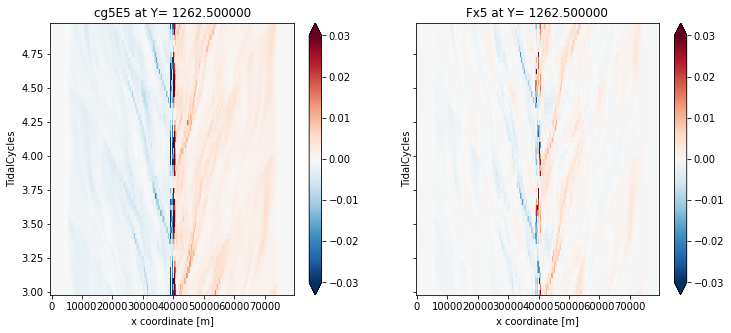

In [41]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=5).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.03,vmax=0.03,rasterized=True)
ax[0].set_title("cg5E5 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=5).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.03,vmax=0.03,rasterized=True)
ax[1].set_title("Fx5 at Y= %1f" %yc[iy1])

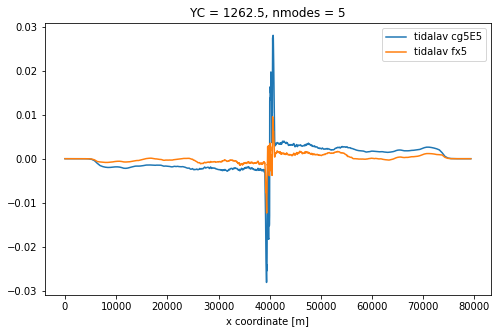

In [42]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=5).plot(ax=ax,label="tidalav cg5E5")
fxm.mean("TidalCycles").sel(nmodes=5).plot(ax=ax,label="tidalav fx5")

ax.legend()

Text(0.5, 1.0, 'Fx6 at Y= 1262.500000')

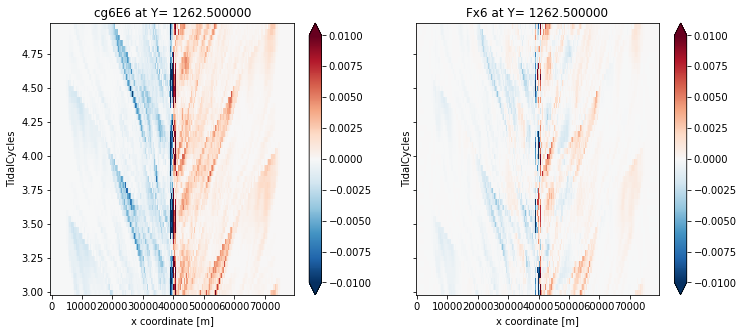

In [43]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=6).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.01,vmax=0.01,rasterized=True)
ax[0].set_title("cg6E6 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=6).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.01,vmax=0.01,rasterized=True)
ax[1].set_title("Fx6 at Y= %1f" %yc[iy1])

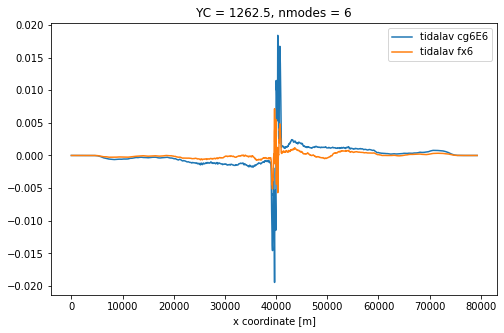

In [44]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=6).plot(ax=ax,label="tidalav cg6E6")
fxm.mean("TidalCycles").sel(nmodes=6).plot(ax=ax,label="tidalav fx6")

ax.legend()